#### Model v6.1 (.85)

In [ ]:
#model v6.1 used alpha of .4 in my emas

#model v6.11 uses alpha of .2

# === Inputs ===
modis_input = layers.Input(shape=(46, 128, 128, 10), name="modis_input")
weather_input = layers.Input(shape=(365, 7), name="weather_input")
ema_input = layers.Input(shape=(1,), name="ema_input")  # EMA is a scalar per sample

# === CNN Branch ===
x = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(modis_input)
x = layers.MaxPooling3D((1,2,2))(x)
x = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(x)
x = layers.Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)
x = layers.Flatten()(x)

# === Weather Branch ===
w = layers.LSTM(128, return_sequences=False)(weather_input)
w = layers.Dense(64, activation='relu')(w)

# === Concatenate all branches ===
combined = layers.Concatenate()([x, w, ema_input])

# === Final Dense Layers ===
z = layers.Dense(128, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(1, activation='linear')(z)

# === Build Model ===
model = models.Model(inputs=[modis_input, weather_input, ema_input], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ modis_input         │ (None, 46, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 10)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 46, 128,   │      8,672 │ modis_input[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 46, 64,    │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 46, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 46, 64,    │    221,312 │ conv3d_1[0][0]    │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 365, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 46, 21,    │          0 │ conv3d_2[0][0]    │
│ (MaxPooling3D)      │ 21, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     69,632 │ weather_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2596608)   │          0 │ max_pooling3d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ema_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2596673)   │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0],      │
│                     │                   │            │ ema_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 332,374,2… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,737,633 (1.24 GB)

 Trainable params: 332,737,633 (1.24 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet-ema.keras',               # save path
    monitor='val_loss',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [ ]:
import numpy as np
import tensorflow as tf

# Memory-mapped loading
# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_10.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_10.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_10.npy', mmap_mode='r')

#weather arrays
X_train_w=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_w.npy', mmap_mode='r')
X_val_w=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_w.npy', mmap_mode='r')

#ema

X_train_ema=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_ema.npy',mmap_mode='r')
X_val_ema=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_ema.npy',mmap_mode='r')



def train_gen():
    for i in range(len(X_train)):
        yield {
            "modis_input": X_train[i],
            "weather_input": X_train_w[i],
            "ema_input": X_train_ema[i]
        }, y_train[i]

def val_gen():
    for i in range(len(X_val)):
        yield {
            "modis_input": X_val[i],
            "weather_input": X_val_w[i],
            "ema_input": X_val_ema[i]
        }, y_val[i]

# === Wrap with tf.data.Dataset ===
BATCH_SIZE = 12

train_ds = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
        {
            "modis_input": tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
            "weather_input": tf.TensorSpec(shape=(365, 7), dtype=tf.float32),
            "ema_input": tf.TensorSpec(shape=(1,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        {
            "modis_input": tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
            "weather_input": tf.TensorSpec(shape=(365, 7), dtype=tf.float32),
            "ema_input": tf.TensorSpec(shape=(1,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Train model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
     66/Unknown 408s 6s/step - loss: 1201.1168 - mae: 27.9739 - mse: 1201.1168

c:\Users\porter77.BYU\AppData\Local\anaconda3\envs\default_dev\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 553.92975, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet-ema.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 455s 7s/step - loss: 1196.0844 - mae: 27.9056 - mse: 1196.0844 - val_loss: 553.9297 - val_mae: 19.0657 - val_mse: 553.9297
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 549.1099 - mae: 19.1351 - mse: 549.1099
Epoch 2: val_loss improved from 553.92975 to 428.28705, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet-ema.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 462s 7s/step - loss: 548.2205 - mae: 19.1167 - mse: 548.2205 - val_loss: 428.2870 - val_mae: 16.4062 - val_mse: 428.2870
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 356.6625 - mae: 15.0856 - mse: 356.6625
Epoch 3: val_loss improved from 428.28705 to 352.37836, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Hur

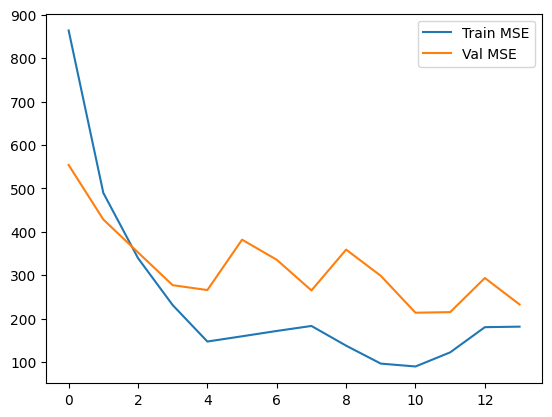

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [ ]:
model=models.load_model(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet-ema.keras')

In [ ]:
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy', mmap_mode='r')
X_weather = np.load(r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\X_weather_stacked.npy", mmap_mode='r')
X_ema=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_ema.npy', mmap_mode='r')




y_pred = model.predict(
    {"modis_input": X, "weather_input": X_weather, "ema_input": X_ema},
    batch_size=12  # Try 1, 2, 4, 8 
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = y  # actual values
y_pred_flat = y_pred.squeeze()  # or np.diag(y_pred) depending on shape

# R²
r2 = r2_score(y_true, y_pred_flat)

# MAE
mae = mean_absolute_error(y_true, y_pred_flat)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))

# MAPE (avoid division by zero)
mape = np.mean(np.abs((y_true - y_pred_flat) / np.clip(y_true, a_min=1e-8, a_max=None))) * 100

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


R²:   0.8556
MAE:  6.2161
RMSE: 8.7542
MAPE: 14.40%


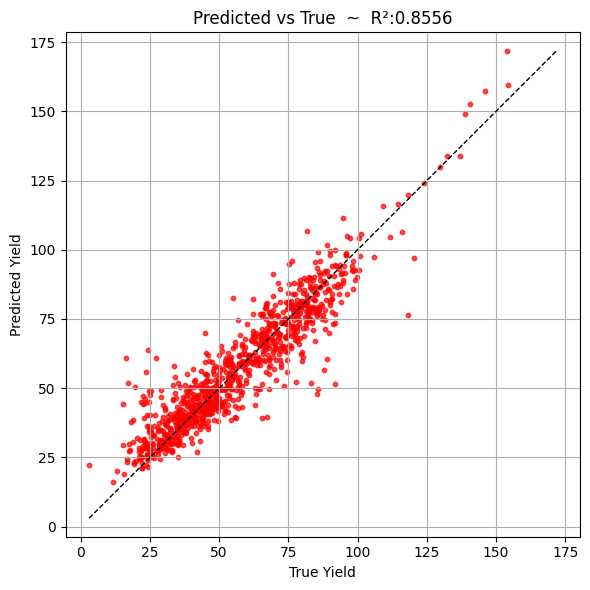

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs True  ~  R²:{np.round(r2,4)}')
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()


In [ ]:
yields['y_pred']=y_pred

In [ ]:
huron_yields=yields[yields['Index']==197]
huron_yields

,fips,Index,Year,yield,y_pred
6351,26063,197,2019,88.9,101.575623
6350,26063,197,2020,94.7,111.608131
6349,26063,197,2021,91.7,99.969254
6348,26063,197,2022,97.9,92.674362
6347,26063,197,2023,105.9,97.515556


#### Model v6.0 (.82)

In [ ]:
#model 6.0

# === Inputs ===
modis_input = layers.Input(shape=(46, 128, 128, 10), name="modis_input")
weather_input = layers.Input(shape=(365, 7), name="weather_input")

# === CNN Branch ===
x = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(modis_input)
x = layers.MaxPooling3D((1,2,2))(x)
x = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(x)
x = layers.Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)
x = layers.Flatten()(x)

# === Weather BranchSSS ===
w = layers.LSTM(128, return_sequences=False)(weather_input)
w = layers.Dense(64, activation='relu')(w)

# === Concatenate ===
combined = layers.Concatenate()([x, w])

# === Final Dense Layers ===
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='linear')(x)

# === Build Model ===
model = models.Model(inputs=[modis_input, weather_input], outputs=output)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ modis_input         │ (None, 46, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 10)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 46, 128,   │      8,672 │ modis_input[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 46, 64,    │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 46, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 46, 64,    │    221,312 │ conv3d_1[0][0]    │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 365, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 46, 21,    │          0 │ conv3d_2[0][0]    │
│ (MaxPooling3D)      │ 21, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     69,632 │ weather_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2596608)   │          0 │ max_pooling3d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2596672)   │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 332,374,1… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,737,505 (1.24 GB)

 Trainable params: 332,737,505 (1.24 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet.keras',               # save path
    monitor='val_loss',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [ ]:
import numpy as np
import tensorflow as tf

# Memory-mapped loading
# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_10.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_10.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_10.npy', mmap_mode='r')

#weather arrays
X_train_w=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_w.npy', mmap_mode='r')
X_val_w=np.load(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_w.npy', mmap_mode='r')


def train_gen():
    for i in range(len(X_train)):
        yield {
            "modis_input": X_train[i],
            "weather_input": X_train_w[i]
        }, y_train[i]

def val_gen():
    for i in range(len(X_val)):
        yield {
            "modis_input": X_val[i],
            "weather_input": X_val_w[i]
        }, y_val[i]


# Wrap with tf.data.Dataset
BATCH_SIZE = 12

train_ds = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
        {
            "modis_input": tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
            "weather_input": tf.TensorSpec(shape=(365, 7), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        {
            "modis_input": tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
            "weather_input": tf.TensorSpec(shape=(365, 7), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
     66/Unknown 414s 6s/step - loss: 1304.9137 - mae: 28.8785 - mse: 1304.9137

c:\Users\porter77.BYU\AppData\Local\anaconda3\envs\default_dev\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 477.26010, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 462s 7s/step - loss: 1299.3142 - mae: 28.8050 - mse: 1299.3142 - val_loss: 477.2601 - val_mae: 17.7065 - val_mse: 477.2601
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 508.0862 - mae: 18.3660 - mse: 508.0862
Epoch 2: val_loss improved from 477.26010 to 416.44022, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 460s 7s/step - loss: 507.7953 - mae: 18.3594 - mse: 507.7953 - val_loss: 416.4402 - val_mae: 16.1765 - val_mse: 416.4402
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 377.8178 - mae: 15.5648 - mse: 377.8178
Epoch 3: val_loss improved from 416.44022 to 410.21536, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield

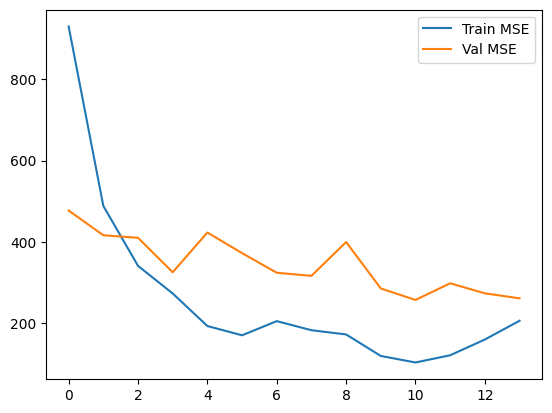

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [ ]:
model=models.load_model(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel-daymet.keras')

In [ ]:
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy', mmap_mode='r')
X_weather = np.load(r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\X_weather_stacked.npy", mmap_mode='r')




y_pred = model.predict(
    {"modis_input": X, "weather_input": X_weather},
    batch_size=4  # Try 1, 2, 4, 8 
)

248/248 ━━━━━━━━━━━━━━━━━━━━ 163s 626ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = y  # actual values
y_pred_flat = y_pred.squeeze()  # or np.diag(y_pred) depending on shape

# R²
r2 = r2_score(y_true, y_pred_flat)

# MAE
mae = mean_absolute_error(y_true, y_pred_flat)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))

# MAPE (avoid division by zero)
mape = np.mean(np.abs((y_true - y_pred_flat) / np.clip(y_true, a_min=1e-8, a_max=None))) * 100

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


R²:   0.8298
MAE:  6.7458
RMSE: 9.5036
MAPE: 15.19%


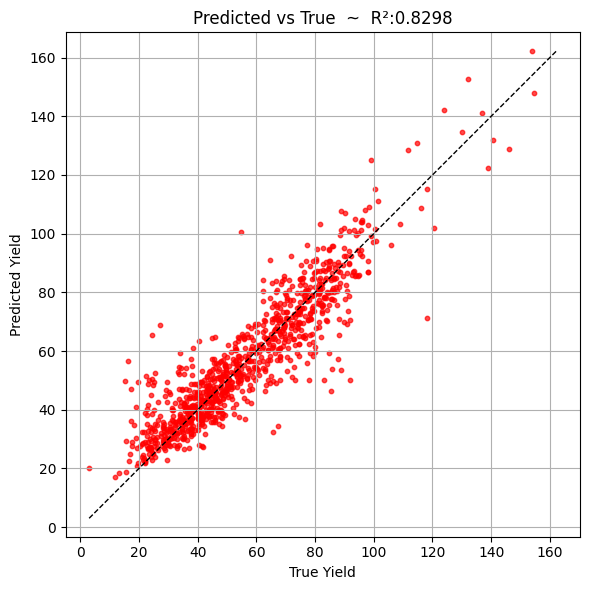

In [ ]:



import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs True  ~  R²:{np.round(r2,4)}')
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()


In [ ]:
yields['y_pred']=y_pred

In [ ]:
huron_yields=yields[yields['Index']==197]
huron_yields

,fips,Index,Year,yield,y_pred
6351,26063,197,2019,88.9,101.183266
6350,26063,197,2020,94.7,100.186722
6349,26063,197,2021,91.7,94.130539
6348,26063,197,2022,97.9,86.901672
6347,26063,197,2023,105.9,96.067482


#### Modelv5.3 (.81)

In [ ]:
import numpy as np
import tensorflow as tf

# # Load from disk using memory-mapping
# X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_10.npy', mmap_mode='r')
# y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
# X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_10.npy', mmap_mode='r')
# y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_10.npy', mmap_mode='r')



In [ ]:
#5.3 (same as 4.2 but different data)

model = models.Sequential([
    layers.Input(shape=(46, 128, 128, 10)),
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(128,(3,3,3),activation='relu',padding='same'),
    layers.MaxPooling3D(pool_size=(1,3,3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 46, 128, 128,   │         8,672 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 46, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 46, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 46, 64, 64,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 46, 21, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2596608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   332,365,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,651,425 (1.24 GB)

 Trainable params: 332,651,425 (1.24 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel_v5-3.keras',               # save path
    monitor='val_loss',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [ ]:
import numpy as np
import tensorflow as tf

# Memory-mapped loading
# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_10.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_10.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_10.npy', mmap_mode='r')

# Define generators
def train_gen():
    for i in range(len(X_train)):
        yield X_train[i], y_train[i]

def val_gen():
    for i in range(len(X_val)):
        yield X_val[i], y_val[i]

# Wrap with tf.data.Dataset
BATCH_SIZE = 12
train_ds = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
        tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        tf.TensorSpec(shape=(46, 128, 128, 10), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Now train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
     66/Unknown 416s 6s/step - loss: 1233.4619 - mae: 28.6325 - mse: 1233.4619

c:\Users\porter77.BYU\AppData\Local\anaconda3\envs\default_dev\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 528.11176, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel_v5-3.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - loss: 1228.3778 - mae: 28.5628 - mse: 1228.3778 - val_loss: 528.1118 - val_mae: 18.5944 - val_mse: 528.1118
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 490.0518 - mae: 18.0317 - mse: 490.0518
Epoch 2: val_loss improved from 528.11176 to 400.06549, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel_v5-3.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 503s 8s/step - loss: 489.4856 - mae: 18.0198 - mse: 489.4856 - val_loss: 400.0655 - val_mae: 15.7918 - val_mse: 400.0655
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 379.6973 - mae: 15.5414 - mse: 379.6973
Epoch 3: val_loss improved from 400.06549 to 371.11606, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_pre

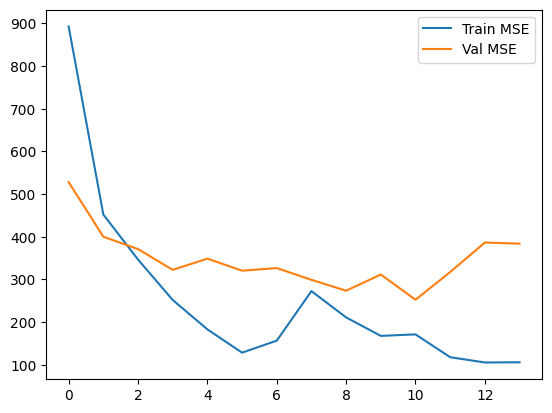

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [ ]:
model=models.load_model(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\10bandmodel_v5-3.keras')

In [ ]:
##load in X
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy', mmap_mode='r')

y_pred=model.predict(X)

31/31 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true=y

# y_true = actual values
# y_pred = your model's predictions

# R²
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


R²:   0.8151
MAE:  7.3746
RMSE: 9.9067


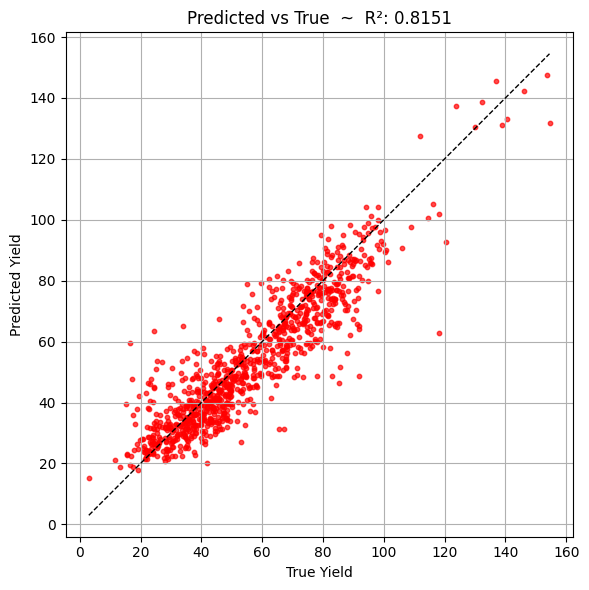

In [ ]:



import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs True  ~  R²: 0.8151')
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()


In [ ]:
huron_yields=yields[yields['Index']==197]
huron_yields

,fips,Index,Year,yield,y_pred
6351,26063,197,2019,88.9,98.313812
6350,26063,197,2020,94.7,98.926804
6349,26063,197,2021,91.7,95.488480
6348,26063,197,2022,97.9,91.657730
6347,26063,197,2023,105.9,90.903244


#### Modelv5.1

In [ ]:
import numpy as np
import tensorflow as tf

# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val.npy', mmap_mode='r')



In [ ]:
#5.1
model = models.Sequential([
    #3d cnn block
    layers.Input(shape=(46, 128, 128, 7)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(128,(3,3,3),activation='relu',padding='same'),
    layers.MaxPooling3D(pool_size=(1,3,3)),
    layers.Conv3D(256,kernel_size=(3,3,3),padding='same',activation='relu'),
    layers.MaxPooling3D(pool_size=(1,2,2)),

    #LSTM block
    layers.ConvLSTM2D(32, (3,3), padding='same', return_sequences=True,recurrent_dropout=.1),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(64, (3,3), padding='same', return_sequences=True,recurrent_dropout=.1),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(64, (3,3), padding='same', return_sequences=False,recurrent_dropout=.1), #goto 32
    layers.BatchNormalization(),

    #last block
    layers.Flatten(),
    layers.Dense(512, activation='relu'), #256
    layers.Dropout(0.4),
    layers.Dense(1, activation='linear')
])



In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 46, 128, 128,   │        12,160 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 46, 64, 64, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 46, 64, 64, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 46, 64, 64,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 46, 21, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 46, 21, 21,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 46, 10, 10,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 46, 10, 10, 32) │       331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 10, 10, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 46, 10, 10, 64) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 10, 10, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 10, 10, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,356,097 (20.43 MB)

 Trainable params: 5,355,777 (20.43 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v5-1.keras',               # save path
    monitor='val_mse',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [ ]:

# Define batch size
BATCH_SIZE = 32

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(1)

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - loss: 2041.2633 - mae: 38.1399 - mse: 2041.2633 
Epoch 1: val_mse improved from inf to 2117.27563, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v4-1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1215s 48s/step - loss: 2013.7721 - mae: 37.7964 - mse: 2013.7721 - val_loss: 2117.2756 - val_mae: 40.4192 - val_mse: 2117.2756
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - loss: 610.3921 - mae: 20.3323 - mse: 610.3921 
Epoch 2: val_mse improved from 2117.27563 to 1792.14221, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v4-1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1060s 42s/step - loss: 609.2914 - mae: 20.3095 - mse: 609.2914 - val_loss: 1792.1422 - val_mae: 36.4472 - val_mse: 1792.1422
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - loss: 589.0792 - mae: 19.7462 - mse: 589.0792 
Epoch 3: val_mse improved from 17

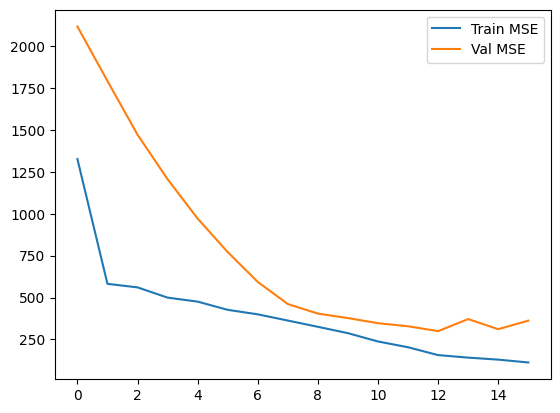

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [ ]:
##load in X
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X.npy', mmap_mode='r')
model=models.load_model(r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\3dcnn-convlstm_v5-1.keras")
y_pred=model.predict(X)

31/31 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true=y

# y_true = actual values
# y_pred = your model's predictions

# R²
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


R²:   0.6199
MAE:  11.3190
RMSE: 14.2045


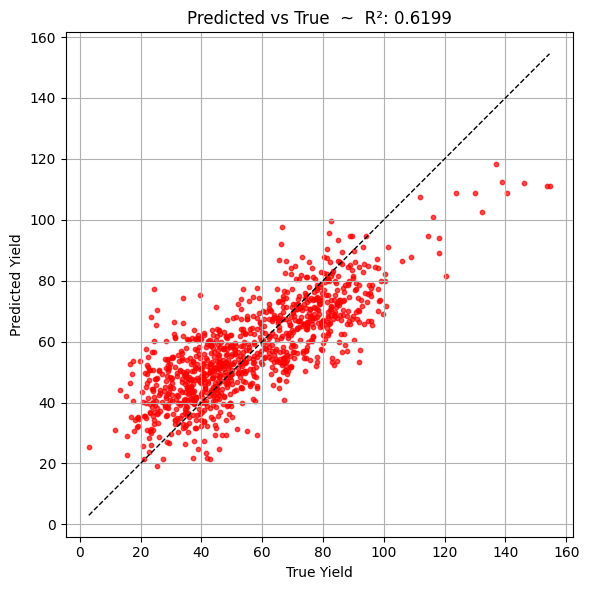

In [ ]:



import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs True  ~  R²: 0.6199')
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()


#### Modelv5.0

In [ ]:
import numpy as np
import tensorflow as tf

# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val.npy', mmap_mode='r')



In [ ]:
#5.0

model = models.Sequential([
    #3d cnn block
    layers.Input(shape=(46, 128, 128, 7)),
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(128,(3,3,3),activation='relu',padding='same'),
    layers.MaxPooling3D(pool_size=(1,3,3)),

    #LSTM block
    layers.ConvLSTM2D(filters=10,kernel_size=(3,3),padding='same',return_sequences=True),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(1,2,2)),
    layers.ConvLSTM2D(filters=5,kernel_size=(3,3),padding='same',return_sequences=False),
    layers.BatchNormalization(),

    #last block
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')




])



In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 46, 128, 128,   │         6,080 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 46, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 46, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 46, 64, 64,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 46, 21, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 46, 21, 21, 10) │        49,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 21, 21, 10) │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 46, 10, 10, 10) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 10, 10, 5)      │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 5)      │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       256,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,277 (2.26 MB)

 Trainable params: 592,247 (2.26 MB)

 Non-trainable params: 30 (120.00 B)

In [ ]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v4-1.keras',               # save path
    monitor='val_mse',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [ ]:

# Define batch size
BATCH_SIZE = 32

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(1)

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 3305.8909 - mae: 52.5375 - mse: 3305.8909 
Epoch 1: val_mse improved from inf to 3240.53149, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v4-1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 420s 16s/step - loss: 3304.2014 - mae: 52.5204 - mse: 3304.2014 - val_loss: 3240.5315 - val_mae: 52.7336 - val_mse: 3240.5315
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 2405.7490 - mae: 42.9681 - mse: 2405.7490 
Epoch 2: val_mse improved from 3240.53149 to 2896.15234, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\best_model_v4-1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 409s 16s/step - loss: 2402.0483 - mae: 42.9222 - mse: 2402.0483 - val_loss: 2896.1523 - val_mae: 49.3056 - val_mse: 2896.1523
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 1452.7250 - mae: 30.4884 - mse: 1452.7250 
Epoch 3: val_mse improved fro

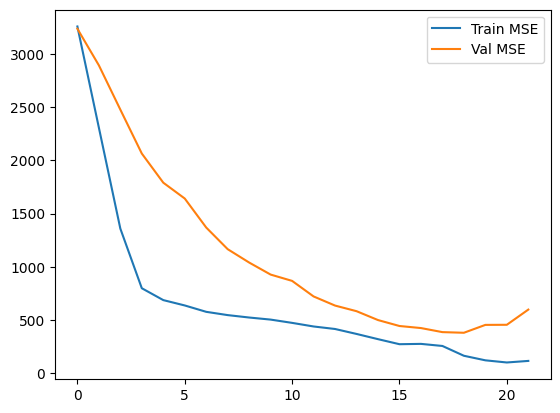

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [ ]:
##load in X
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X.npy', mmap_mode='r')

y_pred=model.predict(X)

31/31 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true=y

# y_true = actual values
# y_pred = your model's predictions

# R²
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


R²:   0.5438
MAE:  12.0711
RMSE: 15.5609


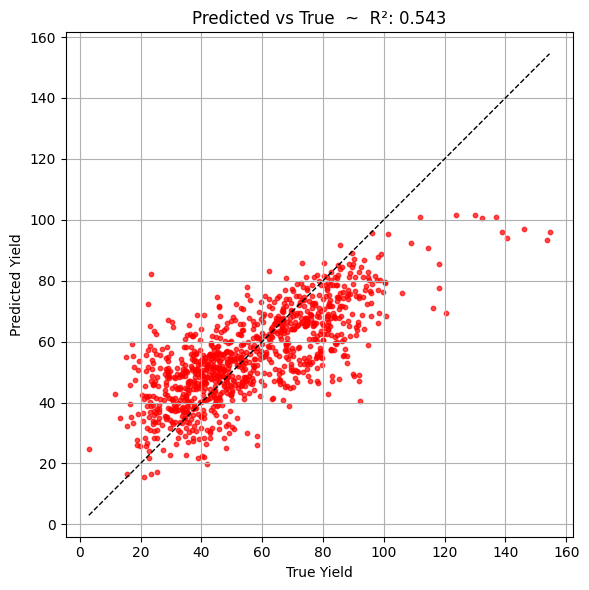

In [ ]:



import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs True  ~  R²: 0.543')
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()


#### Model v4.3 (.74)

In [ ]:
#model 4.3

model = models.Sequential([
    layers.Input(shape=(46, 128, 128, 7)),
    layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((1, 2, 2)),
    layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
    layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(1, 3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])
